# <p style="background-color:#010521 ;font-family:Comic Sans MS; color:white;font-size:150%;text-align:center;border-radius:55px 1px;">Brain Tumor Detection</p>
<center>
<p style="font-family:Comic Sans MS; color:white;font-size:175%;text-align:center;">Using CNN & MRI Images</p>
<img style="border-radius: 15%" src="image.png" width="800" >
</center>
<br>

### Hey everyone,

Today, we're talking about **Brain Tumor Detection**, A CNN model is a powerful computer program that looks at MRI images of the brain to detect tumors. It works by learning from many images, figuring out the difference between healthy and unhealthy brains. This helps doctors quickly and accurately find tumors, making it easier to treat patients.

Let's dive in!


<a class="anchor" id="0"></a>
# **Table of Contents :**


-	[What Is CNN ?](#1)


   - 1. [Implementations](#2)
   - 2. [Data Load & Preprocessing](#3)
   - 3. [Building The CNN Model](#4)
   - 4. [The Loss Journey Plot](#5)
   - 5. [Thresholding and Accuracy Calculation](#6)
   - 6. [Confusion Matrix Plot](#7)

# **What Is CNN ?** <a class="anchor" id="1"></a>

[Table of Contents](#0)


A Convolutional Neural Network (CNN) is a type of deep learning model designed to automatically and efficiently recognize patterns in images and visual data. It's particularly good at tasks like image classification, object detection, and even analyzing medical images. CNNs work by passing the input image through multiple layers of filters that detect features like edges, textures, and shapes, gradually building up an understanding of the image to make accurate predictions or classifications.

Here's a simple graphic to help understand Convolutional Neural Network:

![Wrapper Methods](img.png)

# **Implementations :** <a class="anchor" id="2"></a>
[Table of Contents](#0)
<br>

In [56]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# **Data Load & Preprocessing :** <a class="anchor" id="3"></a>
[Table of Contents](#0)

In [77]:
class MRI:
    def __init__(self):
        # Paths for tumor and healthy images
        tumor_paths = ["./dataset/yes/*.jpg",
                       "./dataset/archive/yes/*.jpg"]
        healthy_paths = ["./dataset/no/*.jpg",
                         "./dataset/archive/no/*.jpg"]

        # Preprocess the images
        self.tumor = self.preprocess_images(tumor_paths)
        self.healthy = self.preprocess_images(healthy_paths)

        # Combine the datasets
        all_imgs = np.concatenate((self.tumor, self.healthy), axis=0)

        # You can create labels here if needed
        tumor_labels = np.ones(self.tumor.shape[0], dtype=np.float32)
        healthy_labels = np.zeros(self.healthy.shape[0], dtype=np.float32)
        all_labels = np.concatenate((tumor_labels, healthy_labels))

        # Normalize the images if needed
        self.images = all_imgs / 255.0
        self.labels = all_labels

    def preprocess_images(self, paths):
        images = []
        for path in paths:
            for f in glob.iglob(path):
                img = cv2.imread(f)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
        return np.array(images)

    def visualize_data(self, num=5):
        # Randomly select 5 images from tumor and healthy datasets
        tumor_samples = self.tumor[np.random.choice(self.tumor.shape[0], num, replace=False)]
        healthy_samples = self.healthy[np.random.choice(self.healthy.shape[0], num, replace=False)]

        # Create a figure with 2 rows and 5 columns
        plt.figure(figsize = (16,9))
        for i in range(num):
          plt.subplot(1, num, i+1)
          plt.title("Healthy")
          plt.imshow(healthy_samples[i])

        plt.figure(figsize = (16, 9))
        for i in range(num):
          plt.subplot(1, num, i+1)
          plt.title("Tumor")
          plt.imshow(tumor_samples[i])

    def train_dev_split(self):
        # Split the data into training and development sets
        self.X_train, self.X_dev, self.y_train, self.y_dev = train_test_split(self.images,  self.labels, test_size=0.2, random_state=42)


## Visualize the data

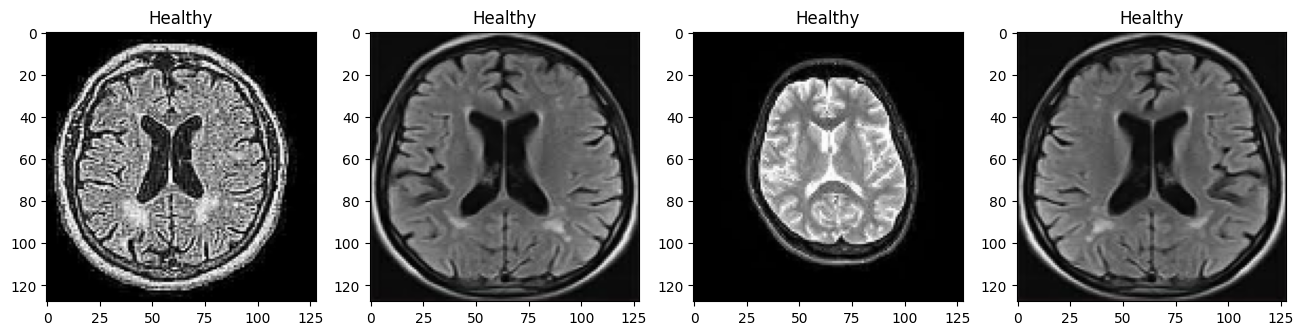

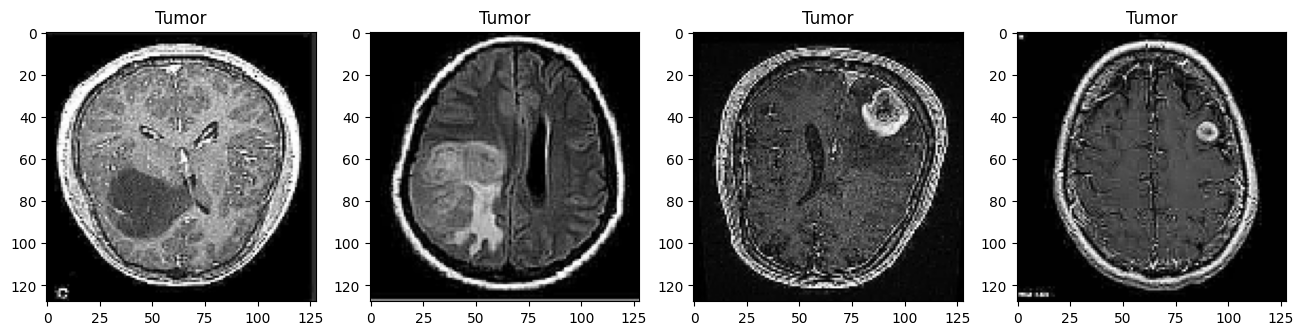

In [82]:
mri = MRI()
mri.visualize_data(4)

In [64]:
mri_dataset = MRI()
mri_dataset.train_dev_split()

In [65]:
print(np.count_nonzero(mri_dataset.labels)) # Tumor Data
print(len(mri_dataset.images)) # All The Data

1586
3171


# **Building The CNN Model :** <a class="anchor" id="4"></a>
[Table of Contents](#0)

In [79]:
model = models.Sequential([    # [Conv --> Max]*2 --> flatten --> [Dense --> Dropout]*2 --> out

    layers.Conv2D(6, kernel_size=5, activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=2, strides=5),

    layers.Conv2D(16, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=5),

    layers.Flatten(),

    layers.Dense(120, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(84, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,961 (171.72 KB)

 Trainable params: 43,961 (171.72 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',       # For two-class classification
    metrics=['accuracy'])             # To Track accuracy during training

In [ ]:
history = model.fit(mri_dataset.X_train, mri_dataset.y_train, epochs=90, batch_size=64, validation_data=(mri_dataset.X_dev, mri_dataset.y_dev))

Epoch 1/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 605ms/step - accuracy: 0.7369 - loss: 0.5309 - val_accuracy: 0.7465 - val_loss: 0.5205
Epoch 2/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 554ms/step - accuracy: 0.7523 - loss: 0.5231 - val_accuracy: 0.7496 - val_loss: 0.5182
Epoch 3/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 677ms/step - accuracy: 0.7524 - loss: 0.5108 - val_accuracy: 0.7465 - val_loss: 0.5097
Epoch 4/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 550ms/step - accuracy: 0.7653 - loss: 0.4901 - val_accuracy: 0.7496 - val_loss: 0.5091
Epoch 5/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step - accuracy: 0.7705 - loss: 0.4934 - val_accuracy: 0.7606 - val_loss: 0.4986
Epoch 6/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 552ms/step - accuracy: 0.7741 - loss: 0.4723 - val_accuracy: 0.7575 - val_loss: 0.4930
Epoch 7/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - accuracy: 0.7785 - loss: 0.4759 - val_accuracy: 0.7669 - val_loss: 0.4914
Epoch 8/90
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 607ms/step - accuracy: 0.7719 - loss: 0.4773 - val_accu

# **The Loss Journey Plot :** <a class="anchor" id="5"></a>
[Table of Contents](#0)

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.history['loss'], c='b', label='Train Loss')
plt.plot(history.history['val_loss'], c='r', label='Validation Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)


In [ ]:
# Generate predictions on the development set
outputs = model.predict(mri_dataset.X_dev).squeeze()  # Predict probabilities and remove extra dimensions

# True labels from the development set
y_true = mri_dataset.y_dev

# **Thresholding and Accuracy Calculation :** <a class="anchor" id="6"></a>
[Table of Contents](#0)

In [ ]:

def threshold(scores, threshold=0.5, minimum=0, maximum=1.0):
    # Convert scores to a NumPy array
    x = np.array(list(scores))
    # Apply the threshold to classify as 1 (tumor) or 0 (healthy)
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

print(f'Accuracy: {accuracy_score(y_true, threshold(outputs))}')

# **Confusion Matrix Plot :** <a class="anchor" id="7"></a>
[Table of Contents](#0)

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,7))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=20)

# **Saving The Model :** <a class="anchor" id="8"></a>
[Table of Contents](#0)
<br>
Now we needa save the model so we don't wait another six minutes to check the results :

In [ ]:
model.save('mri_cnn_model.keras')